# Analyse d'incertitudes

In [1]:
import bw2io as bi # ensemble des fonctions et classes pour importer et exporter (input/output)
import bw2data as bd # ... pour gérer les données du projet
import bw2calc as bc # ... pour faire des opérations
import bw2analyzer as ba # ... pour interpréter les résultats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm # pour les barres de progression

bd.projects.set_current('project_ecoinvent_311')
eidb = bd.Database('ecoinvent-3.11-cutoff')
biodb = bd.Database('ecoinvent-3.11-biosphere')
fgdb = bd.Database('betons_armes')

beton_A = fgdb.search("Béton A")[0]
meth = [m for m in bd.methods if 'EF v3.1' in m[1] and 'no LT' not in m[1]]
gwp100 = [ind for ind in meth if 'GWP100' in str(ind) and 'biogenic' not in str(ind) and 'fossil' not in str(ind) and 'land' not in str(ind)][0]
fw_eutro = [ind for ind in meth if 'eutrophication' in str(ind).lower() and 'freshwater' in str(ind).lower()][0]

14:08:59+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


### Valeur nominale vs valeur moyenne

Nous commençons par réaliser une ACV de béton A prenant en compte les incertitudes sur les valeurs des flux élémentaires et intermédiaires, données par ecoinvent (sur les coefficients des matrices A et B) et sur les facteurs de caractérisation (coefficients de la matrice C). Pour commencer au plus simple, nous nous contentons de faire le calcul uniquement sur l'indicateur de potentiel d'eutrophisation des eaux douces de la méthode d'impact EF v3.1.

Nous réalisons peu de lancers de Monte-Carlo (100) par économie de temps. 

In [2]:
n_MC = 100
lca_unc_A = bc.LCA(demand={beton_A.id : 1.0},method=fw_eutro,use_distributions=True) # L'argument use_distribution=True indique de préparer les matrices pour des tirages aléatoires
lca_unc_A.lci()
lca_unc_A.lcia()

scores_A = [lca_unc_A.score for _ in tqdm(zip(lca_unc_A,range(n_MC)),total= n_MC, desc="Tirages en cours")] #compréhension de liste où "_" itère sur lca_unc_A et range(n_MC) jusqu'à ce que l'un des deux soit entièrement parcouru.

Tirages en cours: 100%|███████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Le résultat obtenu est une liste de n_MC scores :

In [3]:
scores_A # On obtient une liste de résultats

[0.25625715011535494,
 0.3636971772234548,
 0.1542223924935877,
 0.18007250319146748,
 0.271035298948542,
 0.36941269416034417,
 0.09113013793123992,
 0.16880997186808827,
 0.10060661289243104,
 0.14362398006391094,
 0.17781811707266673,
 0.2275732104024929,
 0.3386210573838079,
 0.19718089587176194,
 0.38026258019987186,
 0.15263138036216792,
 0.1262570887021747,
 0.2164225137158962,
 0.1794930692157538,
 0.22908712191777228,
 0.20887832634811418,
 0.25242372000494095,
 0.12942936542870517,
 0.12834789783585143,
 0.188918731584693,
 0.1606112008163026,
 0.23122319813007067,
 0.17134783906690543,
 0.4310310641677721,
 0.16677643506283027,
 0.16249489170851658,
 0.2803544401307088,
 0.33521329166213876,
 0.209241209130529,
 0.15245595719868804,
 0.14578764106820868,
 0.31429845008622975,
 0.10960557166946178,
 0.18530492644798563,
 0.2466498162325622,
 0.16179394341724943,
 0.17506971266756807,
 0.08918247347767867,
 0.30171949176915325,
 0.13234899998230037,
 0.47693882444789404,
 0.31

On peut regarder des statistiques de cette liste comme la moyenne, la médiane, ou encore l'écart type :

In [4]:
scores_mean_A = np.mean(scores_A)
scores_med_A = np.median(scores_A)
scores_std_A = np.std(scores_A)
print('moyenne : ', '%.3f'%scores_mean_A,'\n','médiane : ','%.3f'%scores_med_A,'\n', 'écart-type : ' '%.3f'%scores_std_A)

moyenne :  0.212 
 médiane :  0.194 
 écart-type : 0.091


On peut calculer le score d'impact par ACV sans tirage aléatoire, dite valeur nominale, afin de comparer le comparer aux résultats obtenus par tirages.

In [5]:
lca = bc.LCA(demand={beton_A.id : 1.0},method=fw_eutro)
lca.lci()
lca.lcia()

s = lca.score # s stocke la valeur nominale (score d'eutrophisation des eaux douces)
s

0.1353508516543399

Et tracer ces différents résultats sur un graphe :

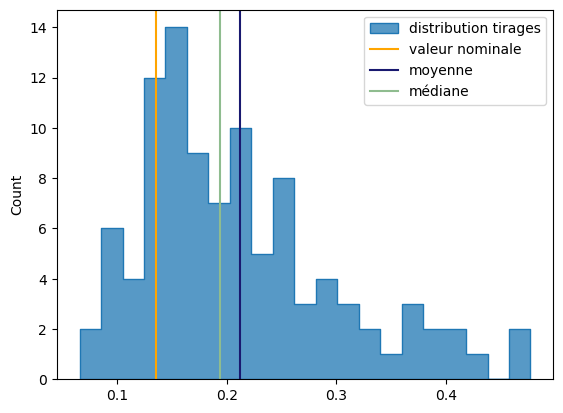

In [6]:

fig, ax = plt.subplots()
sns.histplot(scores_A,binwidth=0.02,element='step',label = "distribution tirages",legend=True) # Tracé de la distribution
ax.axvline(x=s, color='orange',label = 'valeur nominale') # Tracé d'une ligne verticale à la valeur en calcul statique
ax.axvline(x=scores_mean_A, color='midnightblue',label = 'moyenne') # Tracé à la moyenne des tirages
ax.axvline(x=scores_med_A, color='darkseagreen',label = 'médiane') # Tracé à la médiane des tirages
ax.legend(loc='upper right')


On remarque un décalage entre la valeur nominale (score sans tirage) et la moyenne des tirages. Pourquoi ?

On regarde le type d'incertitude renseigné dans les échanges de nos procédés. Ci-dessous, "0" veut dire que l'incertitude n'est pas renseignée, "2" que la distribution est lognormale :

In [7]:
exchanges = [exc.input.exchanges() for exc in beton_A.technosphere()]
uncertainty_types = [[e.uncertainty['uncertainty type'] for e in exc] for exc in exchanges]
print([u for u in uncertainty_types])

[[0, 0, 2, 2, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2], [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 0, 0, 0, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


Ce décalage vient d'un grand nombre d'incertitudes d'ecoinvent qui suivent une loi lognormale, choisie pour de multiples raisons,  notamment pour éviter les valeurs négatives. Pour creuser ce sujet, vous pouvez lire [ce billet](https://chris.mutel.org/ecoinvent-lognormal.html) de Chris Mutel et [cet article](https://link.springer.com/article/10.1007/s11367-013-0670-5) de Ciroth et al. Or la valeur nominale des procédés ecoinvent est la médiane de cette distribution ($e^{\mu}$ si $\mu$ est la moyenne de la distribution normale sous-jacente), qui est toujours inférieure à la moyenne ($e^{\mu +\frac{\sigma^2}{2}}$).

D'où vient l'incertitude ? De la matrice A, de la matrice B, ou de C ? Nous pouvons utiliser un argument pratique de la fonction de calcul ACV de brightway qui permet de choisir sur quelles matrices du calcul les incertitudes sont considérées :

In [8]:
n_MC =100
d_scores_A ={} 
variantes ={'technosphere':[True,False,False],'biosphere':[False,True,False],'caracterisation':[False,False,True]}
for k in variantes.keys():
    lca_unc_A_selectiv = bc.LCA(demand={beton_A.id : 1.0},method=fw_eutro,
    selective_use= {
        "technosphere_matrix" : {"use_distributions" : variantes[k][0]},
        "biosphere_matrix" : {"use_distributions" : variantes[k][1]},
        "characterization_matrix" : {"use_distributions" : variantes[k][2]}
        })
    lca_unc_A_selectiv.lci()
    lca_unc_A_selectiv.lcia()
    d_scores_A[k] = [lca_unc_A_selectiv.score for _ in tqdm(zip(lca_unc_A_selectiv,range(n_MC)),total= n_MC, desc=f"{k} en cours")]

caracterisation en cours: 100%|███████████████| 100/100 [00:08<00:00, 11.37it/s]


On range les résultats dans un tableau pour pouvoir le tracer :

In [9]:
df_scores_A = pd.DataFrame(columns = ['score','uncertainty_on'])
for k,v in d_scores_A.items() :
    for score in v :
        tmp = pd.DataFrame({'score' : [score],'uncertainty_on' : [k]})
        df_scores_A = pd.concat([df_scores_A,tmp])


/tmp/ipykernel_16631/2253789633.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores_A = pd.concat([df_scores_A,tmp])


On trace, et on affiche également les statistiques pour les trois cas :

,moyenne,médiane,écart-type
technosphere,0.155,0.152,0.019
biosphere,0.181,0.166,0.074
caracterisation,0.135,0.135,0.000


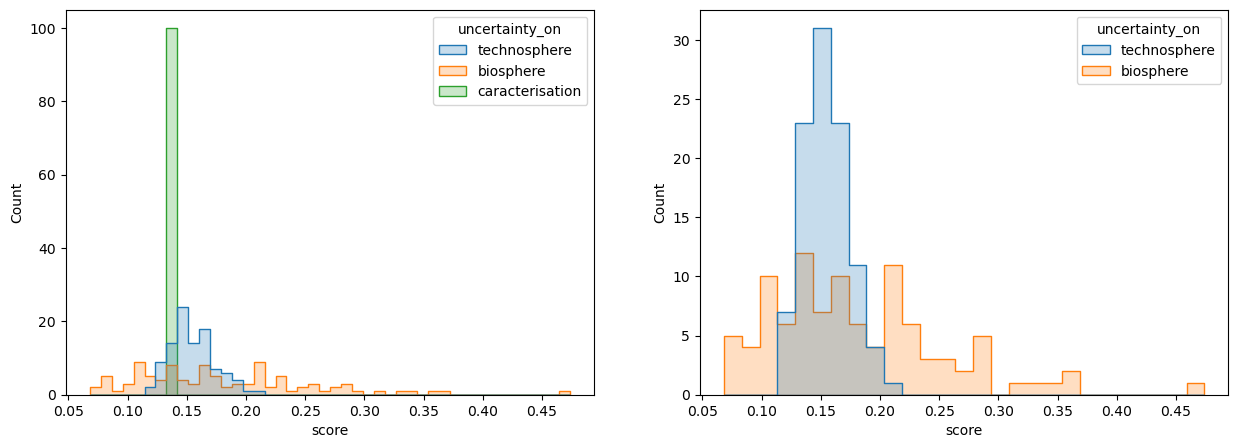

In [10]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(data=df_scores_A,x='score',hue='uncertainty_on',stat="count",element="step",ax=ax[0])
sns.histplot(data=df_scores_A[df_scores_A['uncertainty_on'] != 'caracterisation'],x='score',hue='uncertainty_on',stat="count",element="step",ax=ax[1])

df_stats = pd.DataFrame(index=list(d_scores_A.keys()), columns =['moyenne','médiane','écart-type'])
df_stats['moyenne'] = ['%.3f'%np.mean(v) for v in d_scores_A.values()]
df_stats['médiane'] = ['%.3f'%np.median(v) for v in d_scores_A.values()]
df_stats['écart-type'] = ['%.3f'%np.std(v) for v in d_scores_A.values()]

df_stats

Quelles conclusions tirez-vous ?

### Comparaison sous incertitudes

On veut comparer désormais le béton A et le béton B.

In [11]:
beton_B = fgdb.search("Béton B")[0]

On peut commencer par faire des tirages alétoires afin de calculer l'indicateur de potentiel d'eutrophisation des eaux douces pour une unité de béton B, comme on l'a fait précédemment pour le béton A :

In [12]:
n_MC = 100
lca_unc_B = bc.LCA(demand={beton_B.id : 1.0},method=fw_eutro,use_distributions=True) # L'argument use_distribution=True indique de préparer les matrices pour des tirages aléatoires
lca_unc_B.lci()
lca_unc_B.lcia()
 
scores_B = [lca_unc_B.score for _ in tqdm(zip(lca_unc_B,range(n_MC)),total= n_MC, desc=f"Tirages en cours")]

Tirages en cours: 100%|███████████████████████| 100/100 [01:20<00:00,  1.25it/s]


In [13]:
scores_B

[0.37243955783451593,
 0.3471910326197543,
 0.22791155962537274,
 0.2513857416597999,
 0.18201521085508865,
 0.1141974513876648,
 0.1103293846928348,
 0.13934970994430956,
 0.17531117340609118,
 0.25292201546604914,
 0.12131814902980206,
 0.12740284423862924,
 0.19785779096470685,
 0.13421293700212372,
 0.16734050769291597,
 0.2336382365199127,
 0.38528318325412636,
 0.18518907354430147,
 0.08339819852037454,
 0.12712475767387688,
 0.3444391484700855,
 0.20199669203035067,
 0.21738703797733647,
 0.1243974612987341,
 0.2551194207303529,
 0.1439164073825238,
 0.15532312663530196,
 0.2805225478617943,
 0.3429174962292026,
 0.1737105241975512,
 0.1438035929731668,
 0.18944181433545987,
 0.2064303194013973,
 0.30066579212053113,
 0.13122485200214096,
 0.40827249497767015,
 0.0898096766749564,
 0.2254021991279415,
 0.10137395503941452,
 0.15094110478253886,
 0.18642006495938926,
 0.22796801887163975,
 0.22910376819031816,
 0.34377049988768,
 0.09189841039196545,
 0.17308699747698533,
 0.0906

In [15]:
scores_mean_B = np.mean(scores_B)
scores_med_B = np.median(scores_B)
scores_std_B = np.std(scores_B)
print('moyenne : ', '%.3f'%scores_mean_B ,'\n','médiane : ','%.3f'%scores_med_B ,'\n', 'écart-type : ' '%.3f'%scores_std_B )

moyenne :  0.186 
 médiane :  0.175 
 écart-type : 0.074


On peut désormais tracer les deux distributions de résultats sur le même graphe :

moyenne du béton A :  0.21188693785973825 
 moyenne du béton B :  0.18554009525354695


Text(0.5, 0, "('ecoinvent-3.11', 'EF v3.1', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)')")

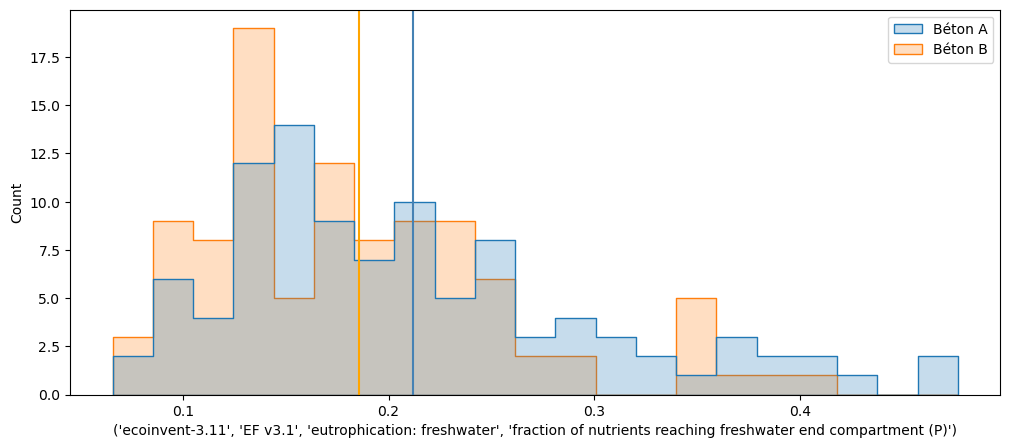

In [16]:
print("moyenne du béton A : ",scores_mean_A,"\n","moyenne du béton B : ",scores_mean_B)
fig, ax = plt.subplots(figsize=(12,5))

sns.histplot({'Béton A' : scores_A,'Béton B' : scores_B},element='step',binwidth=0.02)
ax.axvline(x=np.mean(scores_A), color='steelblue',label = 'moyenne Béton A') # Tracé à la moyenne des tirages
ax.axvline(x=np.mean(scores_B), color='orange',label = 'moyenne Béton B') # Tracé à la médiane des tirages
ax.set_xlabel(str(fw_eutro))


Qu'en pensez-vous ? Sauriez-vous arbitrer entre ces deux bétons ?

#### Dépendante, indépendante

Nous avons réalisé des tirages indépendants, au sens où nous avons tiré indépendamment n_MC fois les coefficients des matrices du calcul ACV pour chaque béton. Nous pourrions considérer que lorsque un coefficient est tiré (par exemple un coefficient de la matrice environnementale comme l'émission de CO2 dans l'air pour une production d'1 kWh électrique en France) pour le béton A il doit rester le même pour le béton B, afin de  ne pas générer de différence là où les deux procédés sont identiques (pour poursuivre l'exemple, on fait l'hypothèse que les bétons A et B sont produits avec le même mix électrique).

In [17]:
demands = [{beton_A.id : 1.0},{beton_B.id : 1.0}] # liste des demandes
lca = bc.LCA(demand=demands[0],method=fw_eutro,use_distributions=True) # On initialise l'ACV, la demande ici importe peu
lca.lci() 
lca.lcia()
tirages = {'Béton A' : [],'Béton B' : []} # dictionnaire de listes vides dans lesquelles on stockera les résultats

for _ in tqdm(range(n_MC),total=n_MC,desc="Tirages en cours") : # On fait n_MC tirages
    next(lca) # On tire les matrices
    lca.redo_lcia(demands[0]) # On calcule la matrice d'inventaire caractérisée pour la demande spécifiée
    tirages['Béton A' ].append(lca.score)
    lca.redo_lcia(demands[1]) # On calcule la matrice d'inventaire caractérisée pour la demande spécifiée, sans changer les matrices A, B et C !!!!!!
    tirages['Béton B' ].append(lca.score)

Tirages en cours: 100%|███████████████████████| 100/100 [01:23<00:00,  1.20it/s]


On range les résultats dans des tableaux, et on trace :

In [18]:
df_comp_dep = pd.DataFrame(tirages)
df_comp_inde = pd.DataFrame({'Béton A':scores_A,'Béton B':scores_B,})

(-0.3, 0.3)

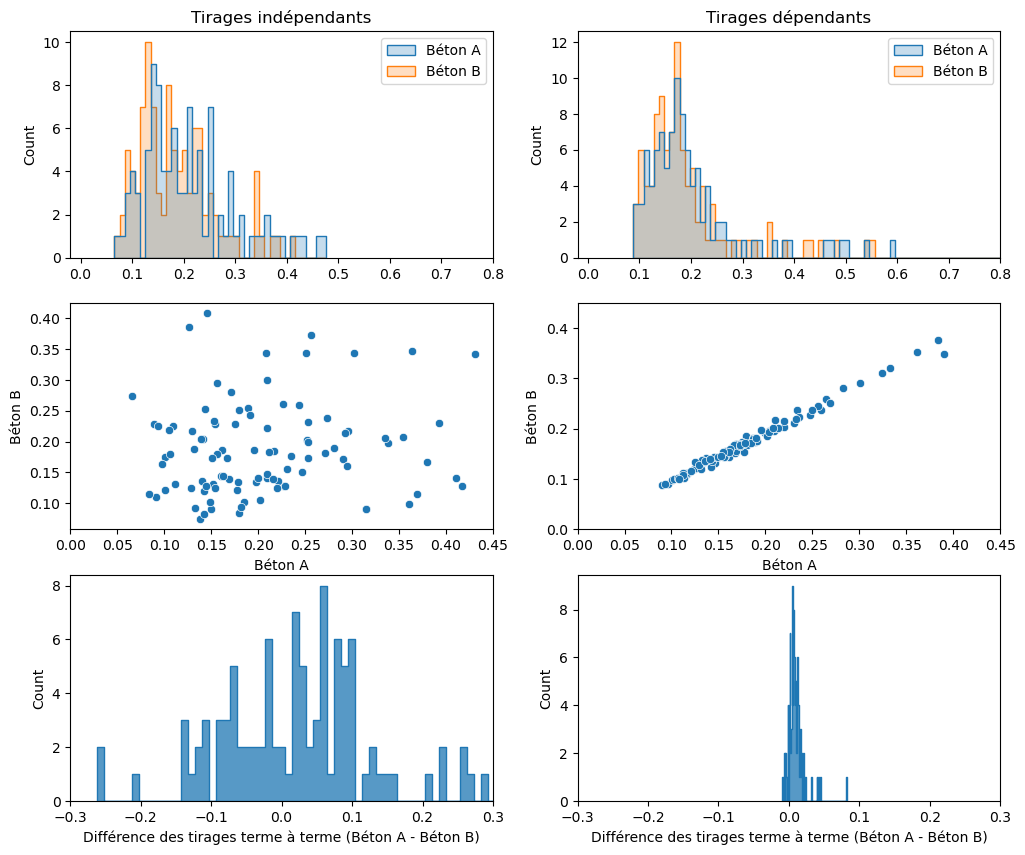

In [19]:
fig, ax = plt.subplots(3,2,figsize=(12,10))
sns.histplot(df_comp_inde,element='step',ax=ax[0,0],binwidth=0.01)
sns.histplot(df_comp_dep,element='step',ax=ax[0,1],binwidth=0.01)
sns.scatterplot(df_comp_inde,x='Béton A',y='Béton B',ax=ax[1,0])
sns.scatterplot(df_comp_dep,x='Béton A',y='Béton B',ax=ax[1,1])
sns.histplot(df_comp_inde['Béton A']-df_comp_inde['Béton B'],element='step',ax=ax[2,0],binwidth=0.01)
sns.histplot(df_comp_dep['Béton A']-df_comp_dep['Béton B'],element='step',ax=ax[2,1],binwidth=0.001)
ax[0,0].set_title(f"Tirages indépendants")
ax[0,0].set_xlim(-0.02,0.8)
ax[0,1].set_title(f"Tirages dépendants")
ax[0,1].set_xlim(-0.02,0.8)
ax[1,0].set_xlim(0,0.45)
ax[1,1].set_xlim(0,0.45)
ax[1,1].set_ylim(0,0.45)
ax[2,0].set_xlabel(f"Différence des tirages terme à terme (Béton A - Béton B)")
ax[2,0].set_xlim(-0.3,0.3)
ax[2,1].set_xlabel(f"Différence des tirages terme à terme (Béton A - Béton B)")
ax[2,1].set_xlim(-0.3,0.3)

On peut confirmer par le calcul ce que l'on aperçoit visuellement, à savoir que la dépendance des comparaisons permet de réduire la dispersion de la différence terme à terme des tirages :

In [20]:
df_stats = pd.DataFrame(columns=['Indépendante','Dépendante'],index=['moyenne',"médiane","écart type"])
delta_inde = df_comp_inde['Béton A']-df_comp_inde['Béton B']
delta_dep = df_comp_dep['Béton A']-df_comp_dep['Béton B']
df_stats['Indépendante'] = [np.mean(delta_inde),np.median(delta_inde),np.std(delta_inde)]
df_stats['Dépendante'] = [np.mean(delta_dep),np.median(delta_dep),np.std(delta_dep)]
df_stats

,Indépendante,Dépendante
moyenne,0.026347,0.009658
médiane,0.029064,0.007283
écart type,0.113298,0.012112


Sauriez-vous arbitrer entre les bétons ? Pourquoi ?

#### Minute théorique

Pour être encore plus explicite, on peut illustrer ce que veut dire une comparaison dépendante/indépendante en comparant le béton A à lui-meme, en prenant en compte les incertitudes.

In [21]:
demand = {beton_A.id : 1.0} # liste des demandes
lca = bc.LCA(demand=demand,method=fw_eutro,use_distributions=True) # On initialise l'ACV
lca.lci() 
lca.lcia()
tirages = {'tirage_1' : [],'tirage_2' : []} # dictionnaire de listes vides dans lesquelles on stockera les résultats

for _ in tqdm(range(n_MC),total=n_MC,desc="Tirages en cours") : # On fait n_MC tirages
    next(lca) # On tire les matrices
    tmp = [] # On crée une liste temporaire pour stocker les résultats sur les deux demandes
    lca.redo_lcia(demand)
    tirages['tirage_1'].append(lca.score)
    lca.redo_lcia(demand)
    tirages['tirage_2'].append(lca.score)



Tirages en cours: 100%|███████████████████████| 100/100 [01:23<00:00,  1.20it/s]


In [22]:
df_tirages_dep = pd.DataFrame(tirages) #On organise nos résultats en une table plus facile à visualiser et tracer
df_tirages_dep

,tirage_1,tirage_2
0,0.266855,0.266855
1,0.128563,0.128563
2,0.116939,0.116939
3,0.139192,0.139192
4,0.224695,0.224695
...,...,...
95,0.150824,0.150824
96,0.192939,0.192939
97,0.178652,0.178652
98,0.328064,0.328064


In [23]:
lca = bc.LCA(demand=demand,method=fw_eutro,use_distributions=True) # On initialise l'ACV
lca.lci() 
lca.lcia()
df_tirages_inde = pd.DataFrame({'tirage_1':[lca.score for _ in tqdm(zip(lca,range(n_MC)),total=n_MC,desc="Tirage 1 en cours")],
                                'tirage_2':[lca.score for _ in tqdm(zip(lca,range(n_MC)),total=n_MC,desc="Tirage 2 en cours")]})

Tirage 2 en cours: 100%|██████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Text(0.5, 0, 'Différence des tirages termes à termes')

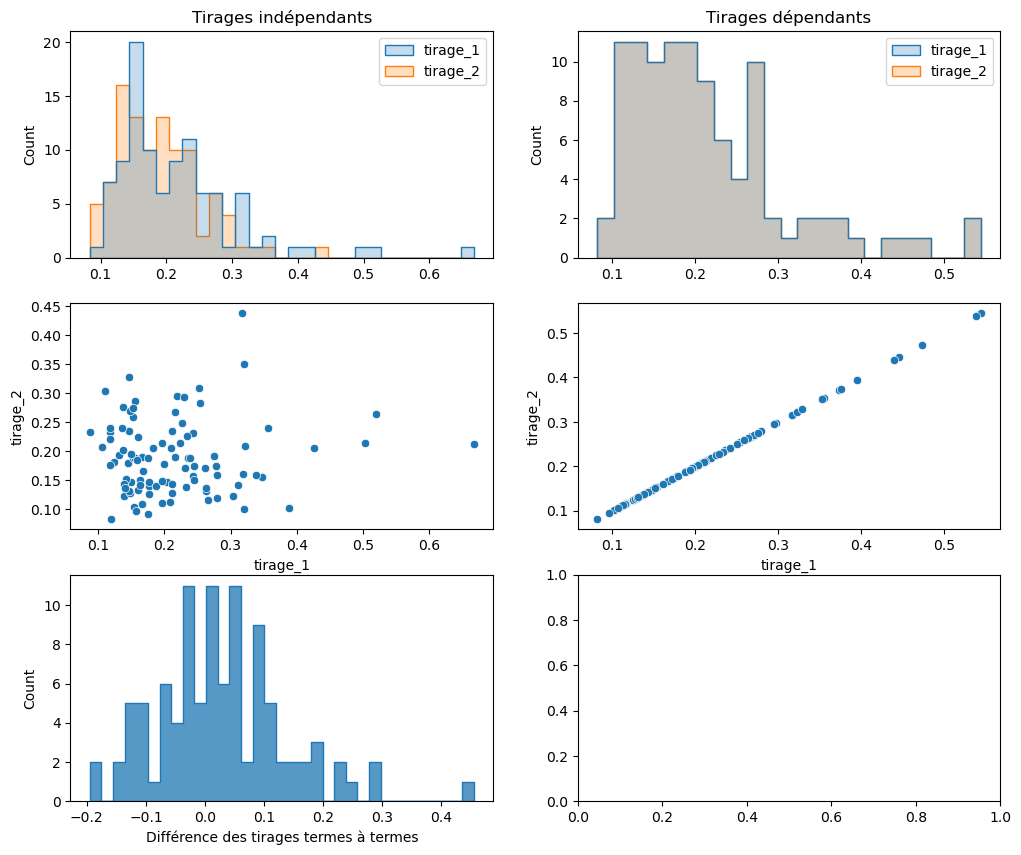

In [24]:
fig, ax = plt.subplots(3,2,figsize=(12,10))
sns.histplot(df_tirages_inde,element='step',ax=ax[0,0],binwidth=0.02)
sns.histplot(df_tirages_dep,element='step',ax=ax[0,1],binwidth=0.02)
sns.scatterplot(df_tirages_inde,x='tirage_1',y='tirage_2',ax=ax[1,0])
sns.scatterplot(df_tirages_dep,x='tirage_1',y='tirage_2',ax=ax[1,1])
sns.histplot(df_tirages_inde['tirage_1']-df_tirages_inde['tirage_2'],element='step',ax=ax[2,0],binwidth=0.02)
# sns.histplot(df_tirages_dep['tirage_1']-df_tirages_dep['tirage_2'],element='step',ax=ax[2,1])
ax[0,0].set_title(f"Tirages indépendants")
ax[0,1].set_title(f"Tirages dépendants")
# ax[2,1].set_xlim(-0.4,0.4)
ax[2,0].set_xlabel(f"Différence des tirages termes à termes")
# ax[2,1].set_xlabel(f"Différence des tirages termes à termes")

Que s'est-il passé ?

#### Indices de discernabilité

Comment choisir objectivement entre A et B ?

Les manières de faire sont nombreuses, ici nous présentons des indices simples de comparaison qui permettent d'objectiver les arbitrages. Pour plus d'informations sur ces indices, vous pouvez lire [cet article](https://doi.org/10.1007/s11367-020-01851-4), où sont indiqués les manières de les calculer ainsi que leurs avantages et inconvénients.

En considèrant la fonction $\Theta(x)$ qui renvoie $1$ si $x>0$ et $0$ sinon, on peut définir un premier indice qui compte le nombre de fois où, sur l'ensemble des tirages, le score de A ($a_i$) est inférieur à celui de B ($b_i$):
$$
K_A = \dfrac{1}{n}\sum_{i=1}^{n}\Theta(b_i-a_i)\\
$$
Cet indice est une comparaison terme à terme des listes de scores et peut être interprété comme une probabilité qu'un échantillon de A soit meilleur qu'un échantillon de B.


In [25]:
def K(A_mc,B_mc) :
    assert len(A_mc) == len(B_mc) , 'Same number of Monte-Carlo runs needed'
    n=len(A_mc)
    ka = (1/n)*sum([
        np.heaviside((B_mc[i]-A_mc[i]),0) for i in range(n)
        ])
    kb = (1/n)*sum([
        np.heaviside((A_mc[i]-B_mc[i]),0) for i in range(n)
        ])
    return {'K_A': ka , 'K_B': kb}

In [26]:
res_K_dep = K(df_comp_dep['Béton A'],df_comp_dep['Béton B'])
res_K_dep

{'K_A': 0.11, 'K_B': 0.89}

In [27]:
res_K_inde = K(df_comp_inde['Béton A'],df_comp_inde['Béton B'])
res_K_inde

{'K_A': 0.39, 'K_B': 0.61}

##### Si jamais on doit faire des tirages indépendants

Un problème de l'indice K est son manque de robustesse : il est sensible à l'ordre des liste. Par exemple, si l'on trie les listes (ce qui n'aurait pas de sens dans le cas d'un tirage dépendant) :

In [28]:
res_K_inde_sorted = K(sorted(df_comp_inde['Béton A']),sorted(df_comp_inde['Béton B'])) # listes triées par ordre croissant
res_K_inde_sorted

{'K_A': 0.01, 'K_B': 0.99}

Pour une comparaison indépendante plus robuste, on peut également choisir de comparer chaque terme de $(a_i)$ à tous les termes de $(b_i)$. Définissons alors $K_2$ :
$$
K_{2,A} = \dfrac{1}{n^2}\sum_{i=1}^{n}\sum_{j=1}^{n}\Theta(b_i-a_j)
$$
Cette indice de comparaison de chacun des termes avec tous ceux de l'autre liste peut être interprété comme la probabilité que A soit meilleur que B.

In [29]:
def K2(A_mc,B_mc):
    assert len(A_mc) == len(B_mc) , 'Same number of Monte-Carlo runs needed'
    n=len(A_mc)
    ka = (1/n)*sum([
        (1/n)*sum([
        np.heaviside((B_mc[i]-A_mc[j]),0) for j in range(n)
        ]) for i in range(n)
        ])
    kb = (1/n)*sum([
        (1/n)*sum([
        np.heaviside((A_mc[i]-B_mc[j]),0) for j in range(n)
        ]) for i in range(n)
        ])
    return {'K2_A': ka , 'K2_B': kb}

In [30]:
res_K2_inde = K2(df_comp_inde['Béton A'],df_comp_inde['Béton B'])
res_K2_inde_sorted = K2(sorted(df_comp_inde['Béton A']),sorted(df_comp_inde['Béton B']))
print(res_K2_inde)

{'K2_A': 0.4155999999999999, 'K2_B': 0.5843999999999999}


In [31]:

res_K2_inde_sorted

{'K2_A': 0.4156000000000002, 'K2_B': 0.5843999999999999}

Que conclure ?